In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ipywidgets import FileUpload, Output
from IPython.display import display

# paths and parameters
TRAIN_DIR = "DATASET/TRAIN/"
TEST_DIR = "DATASET/TEST/"
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 16
EPOCHS_INITIAL = 45
EPOCHS_FINE_TUNE = 20
MODEL_DIR = "./model_uray"
CHECKPOINT_FILE = "model_checkpoint_best_final_1_efnet.keras"
CHECKPOINT_PATH = os.path.join(MODEL_DIR, CHECKPOINT_FILE)
LEARNING_RATE_FINE_TUNE = 1e-5

# Create model directory if not exists
os.makedirs(MODEL_DIR, exist_ok=True)



2024-11-26 00:01:29.766755: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 00:01:29.957339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732554090.040073     334 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732554090.065369     334 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 00:01:30.256871: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.25,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode="nearest",
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle="True"
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)



Found 688 images belonging to 26 classes.
Found 159 images belonging to 26 classes.
Found 208 images belonging to 26 classes.


In [3]:
from tensorflow.keras.regularizers import l2
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)
)

# Build the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu", kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(
    train_generator.num_classes,
    activation="softmax",
    kernel_regularizer=l2(1e-4),
)(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Freeze some of the deeper base model layers
for layer in base_model.layers[:120]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Load checkpoint if exists
if os.path.exists(CHECKPOINT_PATH):
    print("Checkpoint found. Loading model...")
    model = tf.keras.models.load_model(CHECKPOINT_PATH)
else:
    print("No checkpoint found. Training model from scratch...")



I0000 00:00:1732554093.728145     334 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


No checkpoint found. Training model from scratch...


In [4]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8),
    ModelCheckpoint(CHECKPOINT_PATH, monitor="val_accuracy", save_best_only=True, save_weights_only=False, verbose=1),
]



In [5]:
history = model.fit(
    train_generator,
    epochs=EPOCHS_INITIAL,
    validation_data=validation_generator,
    callbacks=callbacks,
)

# Fine-tuning
fine_tune_at = 200  # Unfreeze layers from 200 onwards
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine_tune = model.fit(
    train_generator,
    epochs=EPOCHS_FINE_TUNE,
    validation_data=validation_generator,
    callbacks=callbacks,
)



/root/dev/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/45


I0000 00:00:1732554104.972009     749 service.cc:148] XLA service 0x7f93ac004130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732554104.972352     749 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-11-26 00:01:45.296215: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732554106.404470     749 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1732554120.459899     749 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732554120.647930     749 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1732554129.482

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1491 - loss: 3.8599

/root/dev/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.56604, saving model to ./model_uray/model_checkpoint_best_final_1_efnet.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 54s 473ms/step - accuracy: 0.1512 - loss: 3.8444 - val_accuracy: 0.5660 - val_loss: 1.8939 - learning_rate: 0.0010
Epoch 2/45
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5389 - loss: 1.7996
Epoch 2: val_accuracy improved from 0.56604 to 0.59748, saving model to ./model_uray/model_checkpoint_best_final_1_efnet.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.5390 - loss: 1.7984 - val_accuracy: 0.5975 - val_loss: 1.4501 - learning_rate: 0.0010
Epoch 3/45
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6798 - loss: 1.2441
Epoch 3: val_accuracy improved from 0.59748 to 0.67296, saving model to ./model_uray/model_checkpoint_best_final_1_efnet.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.6796 - loss: 1.2441 - val_accuracy: 0.6730 - val_loss: 1.2022 - learning_rate: 0.0010
Epoch 4/45
43/43 ━━━━━━━━━━

In [6]:
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {validation_loss:.3f}, Validation Accuracy: {validation_accuracy:.2%}")

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.2%}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.8384 - loss: 0.6910
Validation Loss: 0.710, Validation Accuracy: 82.39%
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8704 - loss: 0.6608
Test Loss: 0.614, Test Accuracy: 87.98%


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


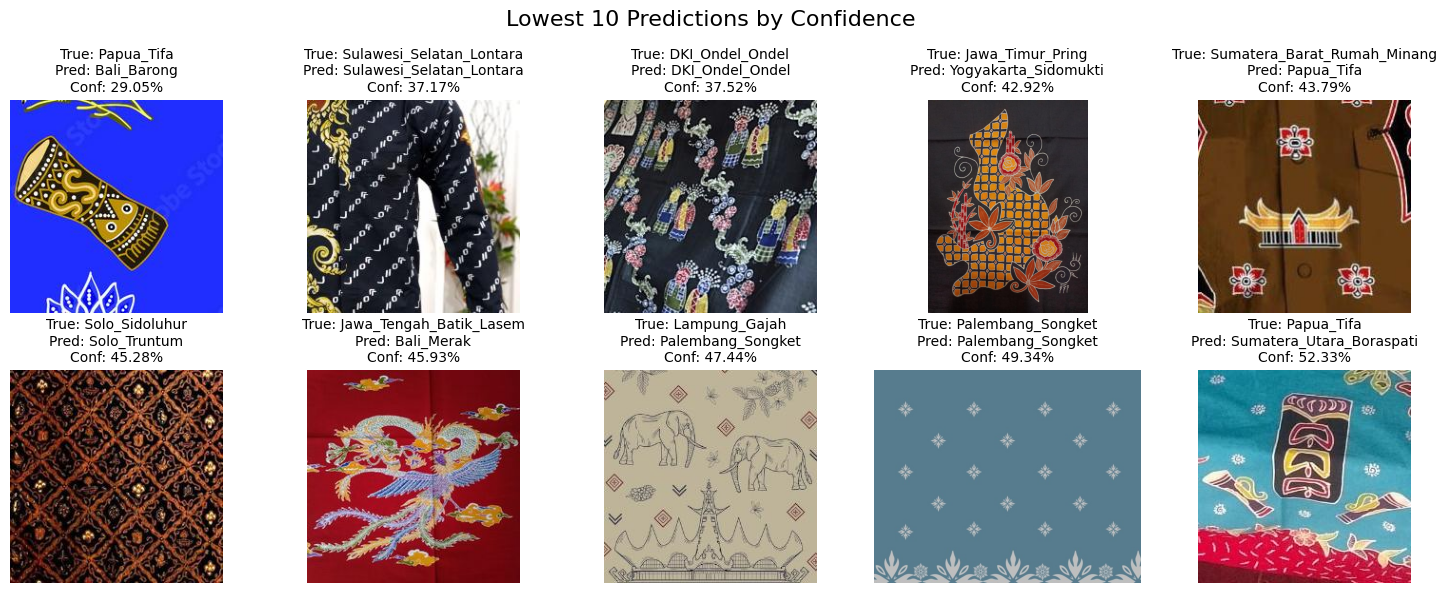

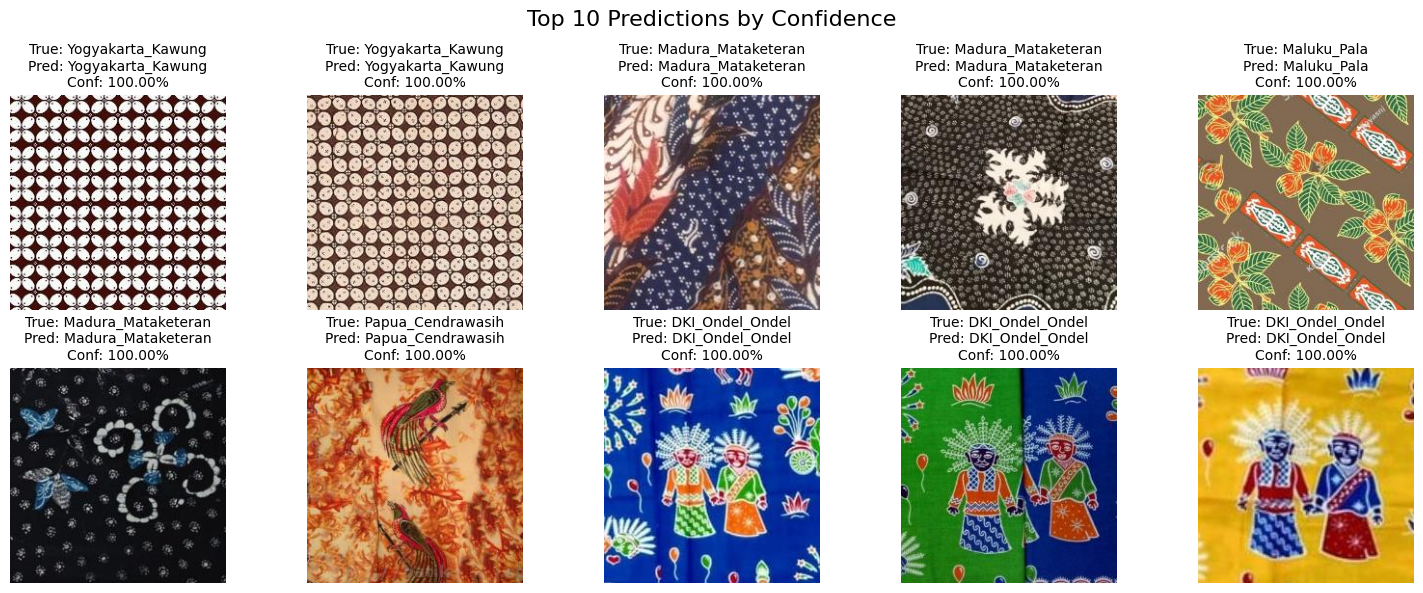

In [7]:
predictions = model.predict(test_generator)
class_labels = list(test_generator.class_indices.keys())
true_indices = test_generator.classes
predicted_indices = np.argmax(predictions, axis=1)
prediction_confidences = np.max(predictions, axis=1)

# Visualization function
def visualize_predictions(indices, title, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    for i, idx in enumerate(indices):
        img_path = test_generator.filepaths[idx]
        img = plt.imread(img_path)
        true_label = class_labels[true_indices[idx]]
        predicted_label = class_labels[predicted_indices[idx]]
        confidence = prediction_confidences[idx] * 100

        ax = axes[i // cols, i % cols]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}%", fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Lowest and highest confidence predictions
low_conf_indices = np.argsort(prediction_confidences)[:10]
high_conf_indices = np.argsort(prediction_confidences)[-10:][::-1]

visualize_predictions(low_conf_indices, "Lowest 10 Predictions by Confidence")
visualize_predictions(high_conf_indices, "Top 10 Predictions by Confidence")



In [8]:
def evaluate_by_folder(generator, predictions):
    folder_results = defaultdict(lambda: {"correct": 0, "total": 0})
    predicted_indices = np.argmax(predictions, axis=1)

    for filepath, true_idx, pred_idx in zip(generator.filepaths, generator.classes, predicted_indices):
        folder = os.path.basename(os.path.dirname(filepath))
        folder_results[folder]["total"] += 1
        if true_idx == pred_idx:
            folder_results[folder]["correct"] += 1

    return {folder: f"{result['correct']}/{result['total']}" for folder, result in folder_results.items()}

folder_results = evaluate_by_folder(test_generator, predictions)
print("Folder-wise Evaluation Results:")
for folder, result in folder_results.items():
    print(f"{folder}: {result}")



Folder-wise Evaluation Results:
Aceh_Pintu_Aceh: 5/8
Bali_Barong: 7/8
Bali_Merak: 8/8
DKI_Ondel_Ondel: 7/8
Jawa_Barat_Megamendung: 8/8
Jawa_Tengah_Batik_Lasem: 6/8
Jawa_Timur_Pring: 7/8
Kalimantan_Barat_Insang: 7/8
Kalimantan_Dayak: 8/8
Lampung_Gajah: 6/8
Madura_Mataketeran: 8/8
Maluku_Pala: 8/8
NTB_Lumbung: 8/8
Palembang_Songket: 8/8
Papua_Asmat: 7/8
Papua_Cendrawasih: 8/8
Papua_Tifa: 6/8
Solo_Parang: 8/8
Solo_Sidoluhur: 4/8
Solo_Sogan: 8/8
Solo_Truntum: 7/8
Sulawesi_Selatan_Lontara: 7/8
Sumatera_Barat_Rumah_Minang: 6/8
Sumatera_Utara_Boraspati: 8/8
Yogyakarta_Kawung: 8/8
Yogyakarta_Sidomukti: 5/8


In [9]:
output = Output()
upload_widget = FileUpload(accept="image/*", multiple=False)
class_labels = list(test_generator.class_indices.keys())

def handle_upload(change):
    output.clear_output()
    with output:
        # Check if a file is uploaded
        if not upload_widget.value:
            print("Please upload an image file.")
            return
        
        # Access uploaded file content
        try:
            # If upload_widget.value is a dict
            if isinstance(upload_widget.value, dict):
                file = list(upload_widget.value.values())[0]
            # If upload_widget.value is a list or tuple
            elif isinstance(upload_widget.value, (list, tuple)):
                file = upload_widget.value[0]
            else:
                print("Unsupported upload format.")
                return

            temp_path = "./uploaded_image.jpg"
            
            # Save the file to a temporary location
            with open(temp_path, "wb") as f:
                f.write(file["content"])
            
            # Load the model from the checkpoint
            if os.path.exists(CHECKPOINT_PATH):
                print("Loading model from checkpoint...")
                loaded_model = tf.keras.models.load_model(CHECKPOINT_PATH)
            else:
                print("No checkpoint found. Ensure the model is trained and checkpoint exists.")
                return
            
            # Load and preprocess the uploaded image
            img = load_img(temp_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
            
            # Make prediction
            preds = loaded_model.predict(img_array)
            predicted_idx = np.argmax(preds)
            confidence = preds[0][predicted_idx] * 100
            predicted_label = class_labels[predicted_idx]
            
            # Display the uploaded image with prediction result
            plt.figure(figsize=(6, 6))
            img_display = plt.imread(temp_path)
            plt.imshow(img_display)
            plt.axis("off")
            plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence:.2f}%", fontsize=14)
            plt.show()
        
        except Exception as e:
            # Catch and display any errors
            print(f"Error during processing: {str(e)}")

# Observe the upload widget
upload_widget.observe(handle_upload, names="value")
display(upload_widget, output)


FileUpload(value=(), accept='image/*', description='Upload')

Output()

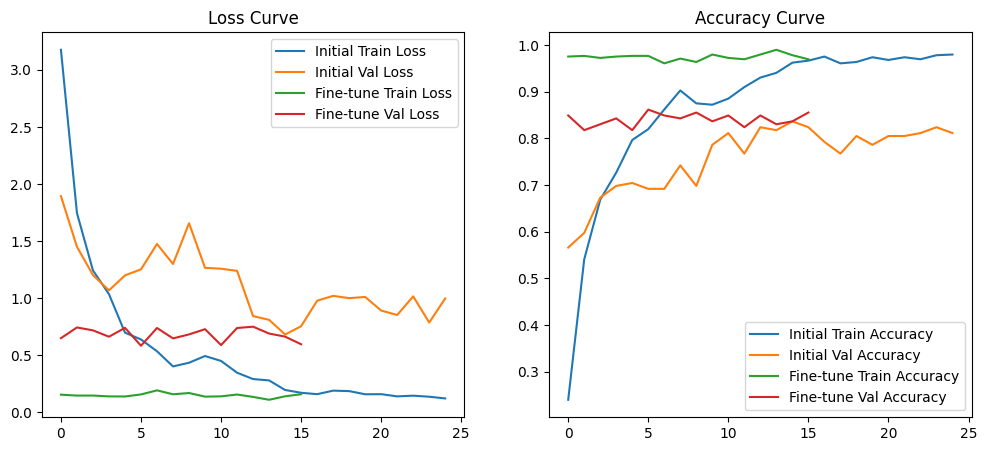

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Initial Train Loss")
plt.plot(history.history["val_loss"], label="Initial Val Loss")
plt.plot(history_fine_tune.history["loss"], label="Fine-tune Train Loss")
plt.plot(history_fine_tune.history["val_loss"], label="Fine-tune Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Initial Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Initial Val Accuracy")
plt.plot(history_fine_tune.history["accuracy"], label="Fine-tune Train Accuracy")
plt.plot(history_fine_tune.history["val_accuracy"], label="Fine-tune Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()



In [16]:
# # Path to the .keras model
keras_model_path = CHECKPOINT_PATH
model = tf.keras.models.load_model(keras_model_path)
model.export("models")

# # Path to save the .h5 model
# h5_model_path = os.path.join(MODEL_DIR, "final_model_h.h5")

# # Step 1: Load the .keras model
# model = tf.keras.models.load_model(keras_model_path)
# print("Model loaded successfully.")

# # Step 2: Save the model in .h5 format
# model.save(h5_model_path, save_format="tf")
# print(f"Model saved successfully to {h5_model_path}.")


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


Saved artifact at 'models'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  140273040015440: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140273040021968: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140273045626832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140273045627216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140273045627984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140273045627024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140273045624336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140273045628176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140273045629136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140273045629904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140273

In [ ]:
# # Save the model architecture to JSON
# model_json = model.to_json()
# with open(os.path.join(MODEL_DIR, 'model_architecture.json'), 'w') as json_file:
#     json_file.write(model_json)
# print("Model architecture saved successfully.")
